# Climate Impact of Methane Combustion (CH4)

Natural gas (methane) is quickly becoming one of the most widely used source of energy in the US and beyond. While it is touted by oil and gas companies as being much cleaner than coal, it is still emits significant amounts of carbon dioxide and other greenhouse gases, not to mention the vast stores of methane being leaked in extraction and transportation. In this exercise, we will attempt to answer the following questions:

1. Approximately how much CO2 is emitted yearly from the combustion of methane? Assume the world uses 160,000 TWh (576,000 *peta*joules) of energy per year and that 25% comes from natural gas ([source](https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/pdfs/energy-economics/statistical-review/bp-stats-review-2019-full-report.pdf)). 
2. The IPCC estimates that an additional 420 gigatonnes (Gt) CO2 added to the atmosphere starting from 2018 would likely result in a 1.5 degC warming relative to pre-industrial levels. If all the world's energy were supplied by methane, how long do we have before this budget runs out? As of July 2020, there are 311 Gt remaining.
3. Similarly, the IPCC estimates that an additional 1170 Gt CO2 added to the atmosphere starting from 2018 would likely result in a 2 degC warming. How long do we have left to avoid this scenario? As of July 2020, there are 1061 Gt remaining.
4. The time left is more accurately estimated [here](https://www.mcc-berlin.net/en/research/co2-budget.html). What are some reasons your model differs?
5. What are some other societal consequences of the mass extraction and consumption of natural gas?

### Brayton Cycle Fueled by Methane (CH4)

To estimate the carbon emitted, we need to know the efficiency at which the thermal energy released from the methane combustion reaction is converted into mechanical work. In practice, most natural gas power plants use a variant of the Brayton Cycle, which operates as follows:

![Brayton Cycle](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Brayton_cycle.svg/1920px-Brayton_cycle.svg.png)

* 1->2: Ambient air (N2 + O2) is compressed from P1 to P2 and experiences a corresponding temperature rise from T1 to T2.
* 2->3: Methane is added to combust with all of the O2 stoichiometrically at constant pressure (isobaric). This brings the temperature of the products from T2 to T3.
* 3->4: The hot combustion products are sent through a turbine and work is extracted, bringing the temperature of the gas from T3 to T4 and the pressure from P3 to P4, which is the same as the ambient air pressure we started with.
* 4->1: The temperature is brought back to the initial temp T1 isobarically. Note in reality, the hot gases are exhausted and replaced with new air, so 4->1 is a hypothetical process. As we will see, this does not affect performance as we do not extract work during this process.

For this exercise we will make the following assumptions:

1. The methane combusts with air (N2 + O2) stoichiometrically to produce CO2 and H2O.
2. The compressor has an isentropic efficiency (Minimum work in / actual work in) of 0.75.
3. The turbine has an isentropic efficiency (Actual work out / maximum work out) of 0.8.
4. The air starts at 300 K and 1 bar (10^5 Pa).
5. All species are in gas phase and are modeled as *ideal* (though not *perfect*).
6. Compressor pressure ratio (P2/P1) = 30.

NOTE: The above diagram is for the *ideal* brayton cycle. For this exercise, we will **not** assume that the compression and expansion happen isentropically.

### Useful Functions / Data

To facilitate your estimations, I have provided the following thermodynamic functions and data that may be helpful to you:

In [ ]:
# All the imports should go here
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
from scipy.optimize import fminbound

# General constants and functions
R = 8.314 # J/mol-K

def enthalpy(T, coeffs): # T in K, coeffs should contain [a1, a2, a3, a4, a5, a6, a7, b1, b2]
  a1 = coeffs[0]
  a2 = coeffs[1]
  a3 = coeffs[2]
  a4 = coeffs[3]
  a5 = coeffs[4]
  a6 = coeffs[5]
  a7 = coeffs[6]
  b1 = coeffs[7]
  b2 = coeffs[8]
  h = R*T*(-a1*T**-2 + a2*np.log(T)/T + a3 + a4*T/2 + a5*(T**2)/3 + a6*(T**3)/4 + a7*(T**4)/5 + b1/T) # J/mol-K
  return(h)

def entropy(T, coeffs): # T in K, coeffs should contain [a1, a2, a3, a4, a5, a6, a7, b1, b2]
  a1 = coeffs[0]
  a2 = coeffs[1]
  a3 = coeffs[2]
  a4 = coeffs[3]
  a5 = coeffs[4]
  a6 = coeffs[5]
  a7 = coeffs[6]
  b1 = coeffs[7]
  b2 = coeffs[8]
  s = R*(-a1/(2*T**2)-a2/T+a3*np.log(T)+a4*T+a5*T**2/2+a6*T**3/3+a7*T**4/4+b2) # J/mol-K
  return(s)

def cp(T, coeffs): # T in K, coeffs should contain [a1, a2, a3, a4, a5, a6, a7, b1, b2]
  a1 = coeffs[0]
  a2 = coeffs[1]
  a3 = coeffs[2]
  a4 = coeffs[3]
  a5 = coeffs[4]
  a6 = coeffs[5]
  a7 = coeffs[6]
  b1 = coeffs[7]
  b2 = coeffs[8]
  cp = R*(a1*T**-2 + a2*T**-1 + a3 + a4*T + a5*T**2 + a6*T**3 + a7*T**4) # J/mol-K
  return(cp)

def cv(T, coeffs): # T in K, coeffs should contain [a1, a2, a3, a4, a5, a6, a7, b1, b2]
  a1 = coeffs[0]
  a2 = coeffs[1]
  a3 = coeffs[2]
  a4 = coeffs[3]
  a5 = coeffs[4]
  a6 = coeffs[5]
  a7 = coeffs[6]
  b1 = coeffs[7]
  b2 = coeffs[8]
  cp = R*(a1*T**-2 + a2*T**-1 + a3 + a4*T + a5*T**2 + a6*T**3 + a7*T**4) # J/mol-K
  return(cp - R)

In [ ]:
%matplotlib inline

Data for thermodynamic properties from NASA found [here](https://www.grc.nasa.gov/WWW/CEAWeb/TP-2002-211556.pdf).

In [ ]:
# Species-specific polynomials and constants:
def nasa_poly_CO2(T):
  if (T >= 200 and T <=1000):
    a1 =  4.943650540e+04
    a2 = -6.264116010e+02
    a3 =  5.301725240e+00
    a4 =  2.503813816e-03
    a5 = -2.127308728e-07
    a6 = -7.689988780e-10
    a7 =  2.849677801e-13
    b1 = -4.528198460e+04
    b2 = -7.048279440e+00
  elif (T > 1000 and T <= 6000):
    a1 =  1.176962419e+05
    a2 = -1.788791477e+03
    a3 =  8.291523190e+00
    a4 = -9.223156780e-05
    a5 =  4.863676880e-09
    a6 = -1.891053312e-12
    a7 =  6.330036590e-16
    b1 = -3.908350590e+04
    b2 = -2.652669281e+01 
  elif (T > 6000):
    a1 = -1.544423287e+09
    a2 =  1.016847056e+06
    a3 = -2.561405230e+02
    a4 =  3.369401080e-02
    a5 = -2.181184337e-06
    a6 =  6.991420840e-11
    a7 = -8.842351500e-16
    b1 = -8.043214510e+06
    b2 =  2.254177493e+03
  return [a1,a2,a3,a4,a5,a6,a7,b1,b2]

def nasa_poly_N2(T):
  if (T >= 200 and T <=1000):
    a1 =  2.210371497e+04
    a2 = -3.818461820e+02
    a3 =  6.082738360e+00
    a4 = -8.530914410e-03
    a5 =  1.384646189e-05
    a6 = -9.625793620e-09
    a7 =  2.519705809e-12
    b1 =  7.108460860e+02
    b2 = -1.076003744e+01
  elif (T > 1000 and T < 6000):
    a1 =  5.877124060e+05
    a2 = -2.239249073e+03 
    a3 =  6.066949220e+00
    a4 = -6.139685500e-04 
    a5 =  1.491806679e-07
    a6 = -1.923105485e-11 
    a7 =  1.061954386e-15 
    b1 =  1.283210415e+04
    b2 = -1.586640027e+01
  elif (T >= 6000):
    a1 =  8.310139160e+08
    a2 = -6.420733540e+05
    a3 =  2.020264635e+02
    a4 = -3.065092046e-02
    a5 =  2.486903333e-06
    a6 = -9.705954110e-11
    a7 =  1.437538881e-15
    b1 =  4.938707040e+06
    b2 = -1.672099740e+03
  return [a1,a2,a3,a4,a5,a6,a7,b1,b2]

def nasa_poly_O2(T):
  if (T >= 200 and T < 1000):
    a1 = -3.425563420e+04 
    a2 =  4.847000970e+02 
    a3 =  1.119010961e+00 
    a4 =  4.293889240e-03
    a5 = -6.836300520e-07
    a6 = -2.023372700e-09 
    a7 =  1.039040018e-12 
    b1 = -3.391454870e+03
    b2 =  1.849699470e+01 
  elif (T >= 1000 and T < 6000):
    a1 = -1.037939022e+06 
    a2 =  2.344830282e+03 
    a3 =  1.819732036e+00 
    a4 =  1.267847582e-03
    a5 = -2.188067988e-07
    a6 =  2.053719572e-11
    a7 = -8.193467050e-16
    b1 = -1.689010929e+04 
    b2 =  1.738716506e+01
  elif (T >= 6000):
    a1 =  4.975294300e+08
    a2 = -2.866106874e+05
    a3 =  6.690352250e+01
    a4 = -6.169959020e-03
    a5 =  3.016396027e-07
    a6 = -7.421416600e-12
    a7 =  7.278175770e-17 
    b1 =  2.293554027e+06
    b2 = -5.530621610e+02
  return [a1,a2,a3,a4,a5,a6,a7,b1,b2]

def nasa_poly_H2O(T): # STEAM
  if (T >= 200 and T < 1000):
    a1 = -3.947960830e+04
    a2 =  5.755731020e+02
    a3 =  9.317826530e-01
    a4 =  7.222712860e-03
    a5 = -7.342557370e-06
    a6 =  4.955043490e-09
    a7 = -1.336933246e-12
    b1 = -3.303974310e+04
    b2 =  1.724205775e+01
  elif (T >= 1000 and T < 6000):
    a1 =  1.034972096e+06
    a2 = -2.412698562e+03
    a3 =  4.646110780e+00
    a4 =  2.291998307e-03
    a5 = -6.836830480e-07
    a6 =  9.426468930e-11
    a7 = -4.822380530e-15
    b1 = -1.384286509e+04
    b2 = -7.978148510e+00
  return [a1,a2,a3,a4,a5,a6,a7,b1,b2]

def nasa_poly_CH4(T):
  if (T >= 200 and T < 1000):
    a1 = -1.766850998e+05
    a2 =  2.786181020e+03
    a3 = -1.202577850e+01
    a4 =  3.917619290e-02
    a5 = -3.619054430e-05
    a6 =  2.026853043e-08
    a7 = -4.976705490e-12
    b1 = -2.331314360e+04
    b2 =  8.904322750e+01
  elif (T >= 1000 and T < 6000):
    a1 =  3.730042760e+06
    a2 = -1.383501485e+04
    a3 =  2.049107091e+01
    a4 = -1.961974759e-03
    a5 =  4.727313040e-07
    a6 = -3.728814690e-11
    a7 =  1.623737207e-15
    b1 =  7.532066910e+04
    b2 = -1.219124889e+02
  return [a1,a2,a3,a4,a5,a6,a7,b1,b2]

In [ ]:
# To use this code, we can find the change in enthalpy across a process by:
T_1_ex = 300 # K
T_2_ex = 500 # K
delta_H_CO2_example = enthalpy(T_2_ex, nasa_poly_CO2(T_2_ex)) - enthalpy(T_1_ex, nasa_poly_CO2(T_1_ex))
print('{} J/mol'.format(delta_H_CO2_example))

8237.622258665448 J/mol


In [ ]:
# Or for convenience, we will define some lambda functions:
h_CO2 = lambda T: enthalpy(T, nasa_poly_CO2(T))
h_N2 = lambda T: enthalpy(T, nasa_poly_N2(T))
h_O2 = lambda T: enthalpy(T, nasa_poly_O2(T))
h_H2O = lambda T: enthalpy(T, nasa_poly_H2O(T))
h_CH4 = lambda T: enthalpy(T, nasa_poly_CH4(T))

# and can instead do the same thing more compactly:
delta_H_CO2_example_2 = h_CO2(T_2_ex) - h_CO2(T_1_ex)
print('{} J/mol'.format(delta_H_CO2_example_2))

8237.622258665448 J/mol


# Your Answers:

Please add your work and answers to the questions below each prompt respectively.

### Question 1:

Approximately how much CO2 is emitted yearly from the combustion of methane? Assume the world uses 160,000 TWh (576,000 *peta*joules) of energy per year and that 25% comes from natural gas ([source](https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/pdfs/energy-economics/statistical-review/bp-stats-review-2019-full-report.pdf)). *Note in the US this percentage is a bit higher at around 32% ([source](https://flowcharts.llnl.gov/content/assets/images/energy/us/Energy_US_2019.png))*.

In [ ]:
# Solve for the different states of the Brayton cycle, per mole of CH4.
# What we ultimately want is the carbon intensity = (kg CO2 / mol CH4) / (w_net)
#     where w_net is J/mol CH4.

# Stoichiometry: CH4 + 2(O2 + 3.773 N2) -> CO2 + 2H2O + 7.55N2

h_products = lambda T: h_CO2(T) + 2*h_H2O(T) + 2*3.773*h_N2(T)
h_reactants = lambda T: h_CH4(T) + 2*h_O2(T) + 2*3.773*h_N2(T)

# Given:
T_1 = 300 # K
P_1 = 1e5 # Pa
pressure_ratio = 30
P_2 = P_1 * pressure_ratio
gamma = 1.4 # for ideal gas
eta_c = 0.75
eta_t = 0.8
P_3 = P_2 # Isobaric combustion
P_4 = P_1 # Isobaric resetting of cycle

# 1->2: Compression (need to solve for T2. Remember eta_c = (h_2s - h_1)/(h_2 - h_1))
#       and h_2s = h(T_2s), where T_2s is the temperature we get from perfect
#       adiabatic compression. Solve iteratively using fminbound.
h_1 = h_reactants(T_1)
T_2s = T_1*(P_2/P_1)**((gamma - 1)/gamma)
h_2s = h_reactants(T_2s)
h_2 = h_1 + (h_2s - h_1)/eta_c
w_12 = h_1 - h_2
# Solve for T_2 iteratively:
T_2 = fminbound(lambda T: np.abs(h_reactants(T) - h_2), 200, 1000)

print("""
1->2:
  h_1: {:.4g} J/mol
  h_2: {:.4g} J/mol
  h_2s: {:.4g} J/mol
  T_2s: {:.4g} J/mol
  T_2: {:.4g} K
  w_12: {:.4g} J/mol CH4
  """.format(h_1, h_2, h_2s, T_2s, T_2, w_12))

# 2->3: Combustion (need to solve for for adiabatic flame temp, T_3):
# Constant pressure combustion so h_3(T_3) = h_2(T_2) => h_products(T_3) - h_reactants(T_2) = 0
T_3 = fminbound(lambda T: np.abs(h_products(T) - h_reactants(T_2)), T_2, 6000)
h_3 = h_products(T_3)
q_23 = h_3 - h_2

print("""
2->3:
  T_3: {:.4g} K
  h_3: {:.4g} J/mol CH4
  q_23: {:.4g} J/mol CH4
  """.format(T_3, h_3, q_23))

# 3->4: Expansion (need to solve for T4. Remember eta_t = (h_4 - h_3)/(h_4s - h_3))
T_4s = T_3*(P_4/P_3)**((gamma - 1)/gamma)
h_4s = h_products(T_4s)
h_4 = eta_t * (h_4s - h_3) + h_3
# Solve for T_4 iteratively:
T_4 = fminbound(lambda T: np.abs(h_products(T) - h_4), 200, 6000)
w_34 = h_3 - h_4

print("""
3->4:
  T_4s: {:.4g} K
  T_4: {:.4g} K
  h_4s: {:.4g} J/mol
  h_4: {:.4g} J/mol
  w_34: {:.4g} J/mol
  """.format(T_4s, T_4, h_4s, h_4, w_34))

# Compute net work (w output by turbine minus w input to compressor)
w_net = w_12 + w_34
LHV = np.abs(h_products(298.15) - h_reactants(298.15))
eff_total = w_net / LHV

print("""
Total System:
  w_net: {:.4g} J/mol CH4
  LHV: {:.4g} J/mol CH4
  First Law Efficiency: {:.2g}
  """.format(w_net, LHV, eff_total))


1->2:
  h_1: -7.401e+04 J/mol
  h_2: 1.485e+05 J/mol
  h_2s: 9.284e+04 J/mol
  T_2s: 792.8 J/mol
  T_2: 940.6 K
  w_12: -2.225e+05 J/mol CH4
  

2->3:
  T_3: 2819 K
  h_3: 1.485e+05 J/mol CH4
  q_23: 0.004669 J/mol CH4
  

3->4:
  T_4s: 1067 K
  T_4: 1441 K
  h_4s: -6.04e+05 J/mol
  h_4: -4.535e+05 J/mol
  w_34: 6.019e+05 J/mol
  

Total System:
  w_net: 3.795e+05 J/mol CH4
  LHV: 8.025e+05 J/mol CH4
  First Law Efficiency: 0.47
  


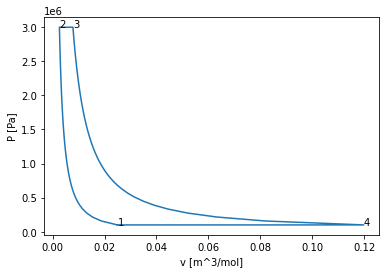

In [ ]:
# Extra: Let's plot this cycle on a PV diagram
P_cycle = [P_1]
v_cycle = [R*T_1/P_1]
T_cycle = [T_1]
Ts_cycle = [T_1]
h_cycle = [h_1]
hs_cycle = [h_1]

# We need to add some points to the curves in order to plot them:

# 1->2
num_steps = 50
for i in range(1, num_steps+1):
  P = P_1 + i/num_steps*(P_2 - P_1)
  T_s = T_1*(P/P_1)**((gamma - 1)/gamma)
  h_s = h_CH4(T_s) + 2*h_O2(T_s) + 2*3.773*h_N2(T_s)
  h = h_1 + (h_s - h_1)/eta_c
  # Solve for T_2 iteratively:
  T = fminbound(lambda T: np.abs(h_CH4(T) + 2*h_O2(T) + 2*3.773*h_N2(T) - h), 200, 1000)
  # Add to arrays
  P_cycle.append(P)
  v_cycle.append(R*T/P)
  T_cycle.append(T)
  Ts_cycle.append(T_s)
  h_cycle.append(h)
  hs_cycle.append(h_s)

# 2->3
P_cycle.append(P_3)
v_cycle.append(R*T_3/P_3)
T_cycle.append(T_3)
Ts_cycle.append(T_3)
h_cycle.append(h_3)
hs_cycle.append(h_3)

# 3->4
num_steps = 50
for i in range(1, num_steps+1):
  P = P_3 + i/num_steps*(P_4 - P_3)
  T_s = T_3*(P/P_3)**((gamma - 1)/gamma)
  h_s = h_products(T_s)
  h = eta_t * (h_s - h_3) + h_3
  # Solve for T_4 iteratively:
  T = fminbound(lambda T: np.abs(h_products(T) - h), 200, 6000)
  # Add to arrays
  P_cycle.append(P)
  v_cycle.append(R*T/P)
  T_cycle.append(T)
  Ts_cycle.append(T_s)
  h_cycle.append(h)
  hs_cycle.append(h_s)

# 4->1
P_cycle.append(P_1)
v_cycle.append(R*T_1/P_1)
T_cycle.append(T_1)
Ts_cycle.append(T_1)
h_cycle.append(h_1)
hs_cycle.append(h_1)

plt.plot(v_cycle, P_cycle, label = 'actual')
plt.xlabel('v [m^3/mol]')
plt.ylabel('P [Pa]')
plt.annotate("1", (R*T_1/P_1, P_1))
plt.annotate("2", (R*T_2/P_2, P_2))
plt.annotate("3", (R*T_3/P_3, P_3))
plt.annotate("4", (R*T_4/P_4, P_4))
plt.show()

In [ ]:
# Compute carbon intensity:

# To figure out carbon intensity, we know we get 1 mol of CO2 per mol CH4 combusted:
M_CO2 = 44.01e-3 # kg/mol
carbon_intensity = 1*M_CO2 / w_net # kg CO2 / J
print("""
Carbon intensity: {:.4g} kg CO2/J
                  {:.4g} g CO2/kWh
""".format(carbon_intensity, carbon_intensity*3600e6))


Carbon intensity: 1.16e-07 kg CO2/J
                  417.5 g CO2/kWh



In [ ]:
# Compute yearly emissions:

# Putting it all together
E_year = 576000e15 # J
E_methane_year = E_year * 0.25
m_CO2_year = carbon_intensity * E_methane_year / 1000 / 1e9 # gigatonnes/year
print('The combustion of methane produces {:.4g} Gt CO2 each year!'.format(m_CO2_year))

The combustion of methane produces 16.7 Gt CO2 each year!


### Question 2:

The IPCC estimates that an additional 420 gigatonnes (Gt) CO2 added to the atmosphere starting from 2018 would likely result in a 1.5 degC warming relative to pre-industrial levels. If all the world's energy were supplied by methane, how long do we have before this budget runs out? As of July 2020, there are 311 Gt remaining.

In [ ]:
m_budget_1p5C = 311 # Gt
t_1p5C = m_budget_1p5C / m_CO2_year * 0.25 # years
print('Assuming these are the only emissions, this budget will run out in about {:.3g} years.'.format(t_1p5C))

Assuming these are the only emissions, this budget will run out in about 4.66 years.


### Question 3:

Similarly, the IPCC estimates that an additional 1170 Gt CO2 added to the atmosphere starting from 2018 would likely result in a 2 degC warming. How long do we have left to avoid this scenario? As of July 2020, there are 1061 Gt remaining.

In [ ]:
m_budget_2C = 1061 # Gt
t_2C = m_budget_2C / m_CO2_year * 0.25 # years
print('Assuming these are the only emissions, this budget will run out in about {:.3g} years.'.format(t_2C))

Assuming these are the only emissions, this budget will run out in about 15.9 years.


### Question 4:

The time left is more accurately estimated [here](https://www.mcc-berlin.net/en/research/co2-budget.html), which estimates total yearly emissions as roughly 42 Gt CO2e / year. What are some reasons your model differs?

It is important to note that our simple model achieved values that were within an order of magnitude of an extremely detailed model of global carbon emissions. Clearly, there is serious power in honing estimation skills. To account for the discrepancy, here are some of the sources of error we introduced into our model via our initial assumptions:

  * The biggest source of error is that we assumed all of the world's energy demand is met by natural gas. This overestimates the carbon emissions by masking renewable energy sources and nuclear, but also underestimates the carbon emissions from burning coal and oil. In total this actually gives us a reasonably good estimate for the minimal amount of analysis.
  * We assume that the combustion happens stoichiometrically but in reality would likely run slightly fuel lean - meaning that more air then is necessary would be used to prevent excessively high flame temperatures at the inlet of the turbine. Taking this into account would reduce our efficiency slightly. Note that real natural gas plants have some other clever methods for getting better efficiency, including utilizing both a high pressure and low pressure turbine, as well as using the waste heat from the exhaust gases to run another heat engine (e.g. tandem Rankine cycle in what is called a "combined cycle" plant) or provide heating for water, etc. Combined cycle plants can achieve efficiences of >50% so our estimate was not too far off.
  * The combustion reaction itself might not fully convert all of the natural gas into CO2 and H2O and instead will produce H2, CO, etc., further reducing our estimated efficiency.
  * We assumed some parameters of the system, including isentropic efficiencies and pressure ratios that might not be representative of all system that use natural gas as a power source.
  * We assumed that all natural gas utilization comes from Brayon Cycle-based power plants. The natural gas used for cooking, for example, does not utilize a Brayton Cycle as we are not trying to extract anything other than heat from the combustion process.

### Question 5:

What are some other societal consequences of the mass extraction and consumption of natural gas? (e.g. fracking on indigenous lands leads to mass displacement)

In addition to the climatological impacts, some things to consider (credit Krystell, Cami, and Sebastian):

*   **Health problems**: The consumption of natural gas causes air pollution. Unconventional gas development can significantly affect air quality. In some regions where mass extraction occurs, there have been increases in concentrations of different air pollutants. Exposure to these pollutants may lead to respiratory, cardiovascular, and oncological problems and adverse effects. 
*   **Water Pollution**: Unconventional oil and gas development has been linked to the contamination of groundwater, surface water, and ultimately potable/drinking water. This poses great health risks since some radioactive materials have leaked into the drinking water, which causes some adverse health effects when one surpasses a certain quantity of ingestion.
*  **Ecosystem damage**: Detrimental effects are very likely to occur due to this practice. Pollutants may enter streams, land may be eroded, and both flora and fauna may be greatly reduced.
*   **Loss of Biodiversity**: As we mentioned before, the flora and fauna may be greatly reduced. This directly translates to a loss of biodiversity that may be extremely detrimental for both the environment and their respective ecosystems.
*   **Other**: Hydraulic fracturing (or simply fracking) has been linked to cause low-magnitude seismic activity.
*   Reference: https://www.ucsusa.org/resources/environmental-impacts-natural-gas
* Displacement of indigenous peoples and destruction of indigenous land.